# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3096576/11490434 [=======>......................] - ETA: 0s

 7692288/11490434 [===================>..........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 57:44 - loss: 0.6939

  15/1875 [..............................] - ETA: 6s - loss: 0.6199   

  31/1875 [..............................] - ETA: 6s - loss: 0.5411

  45/1875 [..............................] - ETA: 6s - loss: 0.4970

  60/1875 [..............................] - ETA: 6s - loss: 0.4646

  74/1875 [>.............................] - ETA: 6s - loss: 0.4422

  88/1875 [>.............................] - ETA: 6s - loss: 0.4248

 101/1875 [>.............................] - ETA: 6s - loss: 0.4116

 114/1875 [>.............................] - ETA: 6s - loss: 0.4004

 127/1875 [=>............................] - ETA: 6s - loss: 0.3907

 143/1875 [=>............................] - ETA: 6s - loss: 0.3804

 156/1875 [=>............................] - ETA: 6s - loss: 0.3730

 169/1875 [=>............................] - ETA: 6s - loss: 0.3664

 184/1875 [=>............................] - ETA: 6s - loss: 0.3594

 200/1875 [==>...........................] - ETA: 6s - loss: 0.3526

 210/1875 [==>...........................] - ETA: 6s - loss: 0.3487

 224/1875 [==>...........................] - ETA: 6s - loss: 0.3436

 239/1875 [==>...........................] - ETA: 6s - loss: 0.3385

 255/1875 [===>..........................] - ETA: 5s - loss: 0.3335

 278/1875 [===>..........................] - ETA: 5s - loss: 0.3268

 296/1875 [===>..........................] - ETA: 5s - loss: 0.3220

 316/1875 [====>.........................] - ETA: 5s - loss: 0.3170

 333/1875 [====>.........................] - ETA: 5s - loss: 0.3131

 349/1875 [====>.........................] - ETA: 5s - loss: 0.3095

 367/1875 [====>.........................] - ETA: 5s - loss: 0.3058

 384/1875 [=====>........................] - ETA: 5s - loss: 0.3025

 400/1875 [=====>........................] - ETA: 5s - loss: 0.2995

 420/1875 [=====>........................] - ETA: 4s - loss: 0.2960

 441/1875 [======>.......................] - ETA: 4s - loss: 0.2925

 459/1875 [======>.......................] - ETA: 4s - loss: 0.2897

 479/1875 [======>.......................] - ETA: 4s - loss: 0.2867

 498/1875 [======>.......................] - ETA: 4s - loss: 0.2839

 516/1875 [=======>......................] - ETA: 4s - loss: 0.2815

 533/1875 [=======>......................] - ETA: 4s - loss: 0.2792

 551/1875 [=======>......................] - ETA: 4s - loss: 0.2769

 566/1875 [========>.....................] - ETA: 4s - loss: 0.2751

 582/1875 [========>.....................] - ETA: 4s - loss: 0.2732

 597/1875 [========>.....................] - ETA: 4s - loss: 0.2715

 614/1875 [========>.....................] - ETA: 4s - loss: 0.2696

 631/1875 [=========>....................] - ETA: 4s - loss: 0.2678

 645/1875 [=========>....................] - ETA: 3s - loss: 0.2663

 665/1875 [=========>....................] - ETA: 3s - loss: 0.2643

 685/1875 [=========>....................] - ETA: 3s - loss: 0.2623

 702/1875 [==========>...................] - ETA: 3s - loss: 0.2607

 720/1875 [==========>...................] - ETA: 3s - loss: 0.2591

 743/1875 [==========>...................] - ETA: 3s - loss: 0.2570

 759/1875 [===========>..................] - ETA: 3s - loss: 0.2556

 775/1875 [===========>..................] - ETA: 3s - loss: 0.2543

 796/1875 [===========>..................] - ETA: 3s - loss: 0.2526

 819/1875 [============>.................] - ETA: 3s - loss: 0.2508

 840/1875 [============>.................] - ETA: 3s - loss: 0.2492

 857/1875 [============>.................] - ETA: 3s - loss: 0.2479

 874/1875 [============>.................] - ETA: 3s - loss: 0.2467

 891/1875 [=============>................] - ETA: 3s - loss: 0.2455

 910/1875 [=============>................] - ETA: 2s - loss: 0.2441

 929/1875 [=============>................] - ETA: 2s - loss: 0.2429

 950/1875 [==============>...............] - ETA: 2s - loss: 0.2415

 969/1875 [==============>...............] - ETA: 2s - loss: 0.2403

 992/1875 [==============>...............] - ETA: 2s - loss: 0.2388

1008/1875 [===============>..............] - ETA: 2s - loss: 0.2379

1028/1875 [===============>..............] - ETA: 2s - loss: 0.2367

1051/1875 [===============>..............] - ETA: 2s - loss: 0.2353

1071/1875 [================>.............] - ETA: 2s - loss: 0.2342

1089/1875 [================>.............] - ETA: 2s - loss: 0.2332

1106/1875 [================>.............] - ETA: 2s - loss: 0.2323

1125/1875 [=================>............] - ETA: 2s - loss: 0.2313

1144/1875 [=================>............] - ETA: 2s - loss: 0.2303

1163/1875 [=================>............] - ETA: 2s - loss: 0.2293

1182/1875 [=================>............] - ETA: 2s - loss: 0.2283

1200/1875 [==================>...........] - ETA: 2s - loss: 0.2274

1218/1875 [==================>...........] - ETA: 1s - loss: 0.2266

1238/1875 [==================>...........] - ETA: 1s - loss: 0.2256

1256/1875 [===================>..........] - ETA: 1s - loss: 0.2248

1275/1875 [===================>..........] - ETA: 1s - loss: 0.2239

1294/1875 [===================>..........] - ETA: 1s - loss: 0.2231

1313/1875 [====================>.........] - ETA: 1s - loss: 0.2222

1337/1875 [====================>.........] - ETA: 1s - loss: 0.2212

1355/1875 [====================>.........] - ETA: 1s - loss: 0.2204

1374/1875 [====================>.........] - ETA: 1s - loss: 0.2196

1388/1875 [=====================>........] - ETA: 1s - loss: 0.2191

1403/1875 [=====================>........] - ETA: 1s - loss: 0.2185

1422/1875 [=====================>........] - ETA: 1s - loss: 0.2177

1445/1875 [======================>.......] - ETA: 1s - loss: 0.2168

1470/1875 [======================>.......] - ETA: 1s - loss: 0.2158

1487/1875 [======================>.......] - ETA: 1s - loss: 0.2152

1509/1875 [=======================>......] - ETA: 1s - loss: 0.2144

1533/1875 [=======================>......] - ETA: 1s - loss: 0.2135

1551/1875 [=======================>......] - ETA: 0s - loss: 0.2129

1571/1875 [========================>.....] - ETA: 0s - loss: 0.2121

1593/1875 [========================>.....] - ETA: 0s - loss: 0.2114

1613/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1634/1875 [=========================>....] - ETA: 0s - loss: 0.2100

1655/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1673/1875 [=========================>....] - ETA: 0s - loss: 0.2087

1692/1875 [==========================>...] - ETA: 0s - loss: 0.2081

1711/1875 [==========================>...] - ETA: 0s - loss: 0.2075

1727/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1744/1875 [==========================>...] - ETA: 0s - loss: 0.2065

1757/1875 [===========================>..] - ETA: 0s - loss: 0.2061

1771/1875 [===========================>..] - ETA: 0s - loss: 0.2056

1791/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1811/1875 [===========================>..] - ETA: 0s - loss: 0.2044

1826/1875 [============================>.] - ETA: 0s - loss: 0.2040

1844/1875 [============================>.] - ETA: 0s - loss: 0.2035

1862/1875 [============================>.] - ETA: 0s - loss: 0.2030

1875/1875 [==============================] - 7s 3ms/step - loss: 0.2026


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1100

  18/1875 [..............................] - ETA: 5s - loss: 0.1128

  38/1875 [..............................] - ETA: 5s - loss: 0.1118

  57/1875 [..............................] - ETA: 5s - loss: 0.1114

  75/1875 [>.............................] - ETA: 5s - loss: 0.1110

  93/1875 [>.............................] - ETA: 5s - loss: 0.1107

 111/1875 [>.............................] - ETA: 4s - loss: 0.1105

 129/1875 [=>............................] - ETA: 4s - loss: 0.1103

 147/1875 [=>............................] - ETA: 4s - loss: 0.1101

 167/1875 [=>............................] - ETA: 4s - loss: 0.1099

 187/1875 [=>............................] - ETA: 4s - loss: 0.1097

 208/1875 [==>...........................] - ETA: 4s - loss: 0.1095

 227/1875 [==>...........................] - ETA: 4s - loss: 0.1094

 248/1875 [==>...........................] - ETA: 4s - loss: 0.1093

 267/1875 [===>..........................] - ETA: 4s - loss: 0.1092

 289/1875 [===>..........................] - ETA: 4s - loss: 0.1090

 314/1875 [====>.........................] - ETA: 4s - loss: 0.1089

 333/1875 [====>.........................] - ETA: 4s - loss: 0.1088

 353/1875 [====>.........................] - ETA: 4s - loss: 0.1088

 378/1875 [=====>........................] - ETA: 3s - loss: 0.1087

 396/1875 [=====>........................] - ETA: 3s - loss: 0.1086

 414/1875 [=====>........................] - ETA: 3s - loss: 0.1085

 434/1875 [=====>........................] - ETA: 3s - loss: 0.1085

 454/1875 [======>.......................] - ETA: 3s - loss: 0.1084

 475/1875 [======>.......................] - ETA: 3s - loss: 0.1083

 488/1875 [======>.......................] - ETA: 3s - loss: 0.1083

 509/1875 [=======>......................] - ETA: 3s - loss: 0.1082

 534/1875 [=======>......................] - ETA: 3s - loss: 0.1081

 556/1875 [=======>......................] - ETA: 3s - loss: 0.1081

 577/1875 [========>.....................] - ETA: 3s - loss: 0.1080

 603/1875 [========>.....................] - ETA: 3s - loss: 0.1079

 624/1875 [========>.....................] - ETA: 3s - loss: 0.1079

 643/1875 [=========>....................] - ETA: 3s - loss: 0.1078

 667/1875 [=========>....................] - ETA: 3s - loss: 0.1077

 680/1875 [=========>....................] - ETA: 3s - loss: 0.1077

 698/1875 [==========>...................] - ETA: 3s - loss: 0.1077

 719/1875 [==========>...................] - ETA: 3s - loss: 0.1076

 739/1875 [==========>...................] - ETA: 2s - loss: 0.1075

 753/1875 [===========>..................] - ETA: 2s - loss: 0.1075

 769/1875 [===========>..................] - ETA: 2s - loss: 0.1075

 787/1875 [===========>..................] - ETA: 2s - loss: 0.1074

 806/1875 [===========>..................] - ETA: 2s - loss: 0.1074

 823/1875 [============>.................] - ETA: 2s - loss: 0.1073

 841/1875 [============>.................] - ETA: 2s - loss: 0.1073

 857/1875 [============>.................] - ETA: 2s - loss: 0.1073

 875/1875 [=============>................] - ETA: 2s - loss: 0.1072

 891/1875 [=============>................] - ETA: 2s - loss: 0.1072

 907/1875 [=============>................] - ETA: 2s - loss: 0.1071

 925/1875 [=============>................] - ETA: 2s - loss: 0.1071

 941/1875 [==============>...............] - ETA: 2s - loss: 0.1071

 957/1875 [==============>...............] - ETA: 2s - loss: 0.1070

 970/1875 [==============>...............] - ETA: 2s - loss: 0.1070

 987/1875 [==============>...............] - ETA: 2s - loss: 0.1070

1007/1875 [===============>..............] - ETA: 2s - loss: 0.1069

1023/1875 [===============>..............] - ETA: 2s - loss: 0.1069

1042/1875 [===============>..............] - ETA: 2s - loss: 0.1068

1060/1875 [===============>..............] - ETA: 2s - loss: 0.1068

1076/1875 [================>.............] - ETA: 2s - loss: 0.1068

1092/1875 [================>.............] - ETA: 2s - loss: 0.1067

1106/1875 [================>.............] - ETA: 2s - loss: 0.1067

1124/1875 [================>.............] - ETA: 2s - loss: 0.1067

1140/1875 [=================>............] - ETA: 2s - loss: 0.1066

1156/1875 [=================>............] - ETA: 2s - loss: 0.1066

1173/1875 [=================>............] - ETA: 1s - loss: 0.1066

1194/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1210/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1229/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1247/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1267/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1279/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1298/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1311/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1324/1875 [====================>.........] - ETA: 1s - loss: 0.1063

1338/1875 [====================>.........] - ETA: 1s - loss: 0.1062

1356/1875 [====================>.........] - ETA: 1s - loss: 0.1062

1373/1875 [====================>.........] - ETA: 1s - loss: 0.1062

1390/1875 [=====================>........] - ETA: 1s - loss: 0.1062

1406/1875 [=====================>........] - ETA: 1s - loss: 0.1061

1422/1875 [=====================>........] - ETA: 1s - loss: 0.1061

1440/1875 [======================>.......] - ETA: 1s - loss: 0.1061

1452/1875 [======================>.......] - ETA: 1s - loss: 0.1060

1466/1875 [======================>.......] - ETA: 1s - loss: 0.1060

1479/1875 [======================>.......] - ETA: 1s - loss: 0.1060

1493/1875 [======================>.......] - ETA: 1s - loss: 0.1060

1510/1875 [=======================>......] - ETA: 1s - loss: 0.1059

1521/1875 [=======================>......] - ETA: 1s - loss: 0.1059

1536/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1554/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1570/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1586/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1600/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1618/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1634/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1651/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1670/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1684/1875 [=========================>....] - ETA: 0s - loss: 0.1056

1702/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1717/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1736/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1757/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1773/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1791/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1806/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1823/1875 [============================>.] - ETA: 0s - loss: 0.1054

1842/1875 [============================>.] - ETA: 0s - loss: 0.1054

1864/1875 [============================>.] - ETA: 0s - loss: 0.1053

1875/1875 [==============================] - 6s 3ms/step - loss: 0.1053


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0869

  29/1875 [..............................] - ETA: 3s - loss: 0.0962

  58/1875 [..............................] - ETA: 3s - loss: 0.0967

  80/1875 [>.............................] - ETA: 3s - loss: 0.0968

  97/1875 [>.............................] - ETA: 3s - loss: 0.0968

 119/1875 [>.............................] - ETA: 3s - loss: 0.0969

 136/1875 [=>............................] - ETA: 3s - loss: 0.0969

 154/1875 [=>............................] - ETA: 3s - loss: 0.0969

 171/1875 [=>............................] - ETA: 4s - loss: 0.0969

 189/1875 [==>...........................] - ETA: 4s - loss: 0.0970

 205/1875 [==>...........................] - ETA: 4s - loss: 0.0970

 223/1875 [==>...........................] - ETA: 4s - loss: 0.0970

 248/1875 [==>...........................] - ETA: 4s - loss: 0.0970

 267/1875 [===>..........................] - ETA: 4s - loss: 0.0970

 281/1875 [===>..........................] - ETA: 4s - loss: 0.0970

 294/1875 [===>..........................] - ETA: 4s - loss: 0.0970

 308/1875 [===>..........................] - ETA: 4s - loss: 0.0970

 321/1875 [====>.........................] - ETA: 4s - loss: 0.0970

 335/1875 [====>.........................] - ETA: 4s - loss: 0.0970

 353/1875 [====>.........................] - ETA: 4s - loss: 0.0971

 366/1875 [====>.........................] - ETA: 4s - loss: 0.0971

 382/1875 [=====>........................] - ETA: 4s - loss: 0.0971

 397/1875 [=====>........................] - ETA: 4s - loss: 0.0971

 414/1875 [=====>........................] - ETA: 4s - loss: 0.0971

 430/1875 [=====>........................] - ETA: 4s - loss: 0.0971

 442/1875 [======>.......................] - ETA: 4s - loss: 0.0971

 460/1875 [======>.......................] - ETA: 4s - loss: 0.0971

 477/1875 [======>.......................] - ETA: 4s - loss: 0.0971

 492/1875 [======>.......................] - ETA: 4s - loss: 0.0971

 510/1875 [=======>......................] - ETA: 4s - loss: 0.0971

 526/1875 [=======>......................] - ETA: 4s - loss: 0.0971

 541/1875 [=======>......................] - ETA: 4s - loss: 0.0971

 557/1875 [=======>......................] - ETA: 4s - loss: 0.0971

 565/1875 [========>.....................] - ETA: 4s - loss: 0.0971

 579/1875 [========>.....................] - ETA: 4s - loss: 0.0971

 592/1875 [========>.....................] - ETA: 4s - loss: 0.0971

 605/1875 [========>.....................] - ETA: 4s - loss: 0.0971

 620/1875 [========>.....................] - ETA: 4s - loss: 0.0971

 635/1875 [=========>....................] - ETA: 3s - loss: 0.0971

 648/1875 [=========>....................] - ETA: 3s - loss: 0.0971

 662/1875 [=========>....................] - ETA: 3s - loss: 0.0972

 683/1875 [=========>....................] - ETA: 3s - loss: 0.0972

 698/1875 [==========>...................] - ETA: 3s - loss: 0.0972

 713/1875 [==========>...................] - ETA: 3s - loss: 0.0972

 728/1875 [==========>...................] - ETA: 3s - loss: 0.0972

 742/1875 [==========>...................] - ETA: 3s - loss: 0.0972

 758/1875 [===========>..................] - ETA: 3s - loss: 0.0972

 775/1875 [===========>..................] - ETA: 3s - loss: 0.0972

 793/1875 [===========>..................] - ETA: 3s - loss: 0.0972

 809/1875 [===========>..................] - ETA: 3s - loss: 0.0972

 820/1875 [============>.................] - ETA: 3s - loss: 0.0972

 836/1875 [============>.................] - ETA: 3s - loss: 0.0972

 852/1875 [============>.................] - ETA: 3s - loss: 0.0972

 870/1875 [============>.................] - ETA: 3s - loss: 0.0972

 886/1875 [=============>................] - ETA: 3s - loss: 0.0972

 900/1875 [=============>................] - ETA: 3s - loss: 0.0972

 916/1875 [=============>................] - ETA: 3s - loss: 0.0972

 931/1875 [=============>................] - ETA: 3s - loss: 0.0972

 944/1875 [==============>...............] - ETA: 3s - loss: 0.0972

 960/1875 [==============>...............] - ETA: 3s - loss: 0.0972

 976/1875 [==============>...............] - ETA: 2s - loss: 0.0972

 991/1875 [==============>...............] - ETA: 2s - loss: 0.0972

1009/1875 [===============>..............] - ETA: 2s - loss: 0.0972

1025/1875 [===============>..............] - ETA: 2s - loss: 0.0972

1046/1875 [===============>..............] - ETA: 2s - loss: 0.0972

1062/1875 [===============>..............] - ETA: 2s - loss: 0.0972

1079/1875 [================>.............] - ETA: 2s - loss: 0.0972

1097/1875 [================>.............] - ETA: 2s - loss: 0.0972

1116/1875 [================>.............] - ETA: 2s - loss: 0.0972

1136/1875 [=================>............] - ETA: 2s - loss: 0.0972

1152/1875 [=================>............] - ETA: 2s - loss: 0.0972

1170/1875 [=================>............] - ETA: 2s - loss: 0.0972

1185/1875 [=================>............] - ETA: 2s - loss: 0.0972

1202/1875 [==================>...........] - ETA: 2s - loss: 0.0972

1220/1875 [==================>...........] - ETA: 2s - loss: 0.0972

1238/1875 [==================>...........] - ETA: 2s - loss: 0.0972

1253/1875 [===================>..........] - ETA: 2s - loss: 0.0972

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0972

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0972

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0972

1318/1875 [====================>.........] - ETA: 1s - loss: 0.0972

1336/1875 [====================>.........] - ETA: 1s - loss: 0.0972

1350/1875 [====================>.........] - ETA: 1s - loss: 0.0972

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0972

1388/1875 [=====================>........] - ETA: 1s - loss: 0.0972

1405/1875 [=====================>........] - ETA: 1s - loss: 0.0972

1421/1875 [=====================>........] - ETA: 1s - loss: 0.0972

1441/1875 [======================>.......] - ETA: 1s - loss: 0.0972

1455/1875 [======================>.......] - ETA: 1s - loss: 0.0972

1471/1875 [======================>.......] - ETA: 1s - loss: 0.0972

1490/1875 [======================>.......] - ETA: 1s - loss: 0.0972

1508/1875 [=======================>......] - ETA: 1s - loss: 0.0971

1525/1875 [=======================>......] - ETA: 1s - loss: 0.0971

1543/1875 [=======================>......] - ETA: 1s - loss: 0.0971

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0971

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0971

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0971

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0971

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0971

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0971

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0971

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0971

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0971

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0971

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0971

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0971

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0971

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0971

1813/1875 [============================>.] - ETA: 0s - loss: 0.0971

1828/1875 [============================>.] - ETA: 0s - loss: 0.0971

1840/1875 [============================>.] - ETA: 0s - loss: 0.0971

1854/1875 [============================>.] - ETA: 0s - loss: 0.0971

1867/1875 [============================>.] - ETA: 0s - loss: 0.0971

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0971


Epoch 4/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0987

  14/1875 [..............................] - ETA: 7s - loss: 0.0980

  27/1875 [..............................] - ETA: 7s - loss: 0.0974

  41/1875 [..............................] - ETA: 7s - loss: 0.0971

  53/1875 [..............................] - ETA: 7s - loss: 0.0969

  66/1875 [>.............................] - ETA: 7s - loss: 0.0967

  79/1875 [>.............................] - ETA: 7s - loss: 0.0966

  94/1875 [>.............................] - ETA: 6s - loss: 0.0965

 104/1875 [>.............................] - ETA: 7s - loss: 0.0964

 119/1875 [>.............................] - ETA: 6s - loss: 0.0963

 130/1875 [=>............................] - ETA: 6s - loss: 0.0963

 146/1875 [=>............................] - ETA: 6s - loss: 0.0963

 158/1875 [=>............................] - ETA: 6s - loss: 0.0962

 173/1875 [=>............................] - ETA: 6s - loss: 0.0962

 185/1875 [=>............................] - ETA: 6s - loss: 0.0962

 199/1875 [==>...........................] - ETA: 6s - loss: 0.0962

 211/1875 [==>...........................] - ETA: 6s - loss: 0.0961

 224/1875 [==>...........................] - ETA: 6s - loss: 0.0961

 235/1875 [==>...........................] - ETA: 6s - loss: 0.0961

 256/1875 [===>..........................] - ETA: 6s - loss: 0.0961

 271/1875 [===>..........................] - ETA: 6s - loss: 0.0961

 289/1875 [===>..........................] - ETA: 6s - loss: 0.0961

 304/1875 [===>..........................] - ETA: 5s - loss: 0.0960

 315/1875 [====>.........................] - ETA: 5s - loss: 0.0960

 325/1875 [====>.........................] - ETA: 5s - loss: 0.0960

 338/1875 [====>.........................] - ETA: 5s - loss: 0.0960

 347/1875 [====>.........................] - ETA: 6s - loss: 0.0960

 358/1875 [====>.........................] - ETA: 5s - loss: 0.0960

 367/1875 [====>.........................] - ETA: 6s - loss: 0.0960

 378/1875 [=====>........................] - ETA: 6s - loss: 0.0960

 388/1875 [=====>........................] - ETA: 6s - loss: 0.0960

 402/1875 [=====>........................] - ETA: 5s - loss: 0.0960

 413/1875 [=====>........................] - ETA: 5s - loss: 0.0960

 424/1875 [=====>........................] - ETA: 5s - loss: 0.0960

 434/1875 [=====>........................] - ETA: 5s - loss: 0.0960

 449/1875 [======>.......................] - ETA: 5s - loss: 0.0960

 464/1875 [======>.......................] - ETA: 5s - loss: 0.0960

 478/1875 [======>.......................] - ETA: 5s - loss: 0.0960

 495/1875 [======>.......................] - ETA: 5s - loss: 0.0960

 512/1875 [=======>......................] - ETA: 5s - loss: 0.0960

 527/1875 [=======>......................] - ETA: 5s - loss: 0.0960

 545/1875 [=======>......................] - ETA: 5s - loss: 0.0960

 565/1875 [========>.....................] - ETA: 5s - loss: 0.0960

 578/1875 [========>.....................] - ETA: 5s - loss: 0.0960

 593/1875 [========>.....................] - ETA: 4s - loss: 0.0960

 607/1875 [========>.....................] - ETA: 4s - loss: 0.0960

 623/1875 [========>.....................] - ETA: 4s - loss: 0.0960

 644/1875 [=========>....................] - ETA: 4s - loss: 0.0960

 658/1875 [=========>....................] - ETA: 4s - loss: 0.0960

 674/1875 [=========>....................] - ETA: 4s - loss: 0.0960

 692/1875 [==========>...................] - ETA: 4s - loss: 0.0960

 710/1875 [==========>...................] - ETA: 4s - loss: 0.0960

 725/1875 [==========>...................] - ETA: 4s - loss: 0.0960

 744/1875 [==========>...................] - ETA: 4s - loss: 0.0960

 760/1875 [===========>..................] - ETA: 4s - loss: 0.0960

 780/1875 [===========>..................] - ETA: 4s - loss: 0.0960

 796/1875 [===========>..................] - ETA: 3s - loss: 0.0960

 810/1875 [===========>..................] - ETA: 3s - loss: 0.0960

 830/1875 [============>.................] - ETA: 3s - loss: 0.0960

 847/1875 [============>.................] - ETA: 3s - loss: 0.0960

 864/1875 [============>.................] - ETA: 3s - loss: 0.0960

 878/1875 [=============>................] - ETA: 3s - loss: 0.0960

 897/1875 [=============>................] - ETA: 3s - loss: 0.0960

 912/1875 [=============>................] - ETA: 3s - loss: 0.0960

 930/1875 [=============>................] - ETA: 3s - loss: 0.0960

 944/1875 [==============>...............] - ETA: 3s - loss: 0.0960

 958/1875 [==============>...............] - ETA: 3s - loss: 0.0960

 977/1875 [==============>...............] - ETA: 3s - loss: 0.0960

 996/1875 [==============>...............] - ETA: 3s - loss: 0.0960

1011/1875 [===============>..............] - ETA: 3s - loss: 0.0960

1024/1875 [===============>..............] - ETA: 3s - loss: 0.0960

1037/1875 [===============>..............] - ETA: 3s - loss: 0.0960

1056/1875 [===============>..............] - ETA: 2s - loss: 0.0960

1070/1875 [================>.............] - ETA: 2s - loss: 0.0960

1085/1875 [================>.............] - ETA: 2s - loss: 0.0960

1102/1875 [================>.............] - ETA: 2s - loss: 0.0959

1115/1875 [================>.............] - ETA: 2s - loss: 0.0959

1129/1875 [=================>............] - ETA: 2s - loss: 0.0959

1146/1875 [=================>............] - ETA: 2s - loss: 0.0959

1163/1875 [=================>............] - ETA: 2s - loss: 0.0959

1178/1875 [=================>............] - ETA: 2s - loss: 0.0959

1195/1875 [==================>...........] - ETA: 2s - loss: 0.0959

1204/1875 [==================>...........] - ETA: 2s - loss: 0.0959

1214/1875 [==================>...........] - ETA: 2s - loss: 0.0959

1225/1875 [==================>...........] - ETA: 2s - loss: 0.0959

1238/1875 [==================>...........] - ETA: 2s - loss: 0.0959

1249/1875 [==================>...........] - ETA: 2s - loss: 0.0959

1258/1875 [===================>..........] - ETA: 2s - loss: 0.0959

1272/1875 [===================>..........] - ETA: 2s - loss: 0.0959

1282/1875 [===================>..........] - ETA: 2s - loss: 0.0959

1293/1875 [===================>..........] - ETA: 2s - loss: 0.0959

1305/1875 [===================>..........] - ETA: 2s - loss: 0.0959

1317/1875 [====================>.........] - ETA: 2s - loss: 0.0959

1330/1875 [====================>.........] - ETA: 2s - loss: 0.0959

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1359/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1382/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1393/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1402/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1413/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1426/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1437/1875 [=====================>........] - ETA: 1s - loss: 0.0959

1448/1875 [======================>.......] - ETA: 1s - loss: 0.0959

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0959

1471/1875 [======================>.......] - ETA: 1s - loss: 0.0959

1485/1875 [======================>.......] - ETA: 1s - loss: 0.0959

1497/1875 [======================>.......] - ETA: 1s - loss: 0.0959

1508/1875 [=======================>......] - ETA: 1s - loss: 0.0959

1524/1875 [=======================>......] - ETA: 1s - loss: 0.0959

1539/1875 [=======================>......] - ETA: 1s - loss: 0.0959

1553/1875 [=======================>......] - ETA: 1s - loss: 0.0959

1571/1875 [========================>.....] - ETA: 1s - loss: 0.0959

1584/1875 [========================>.....] - ETA: 1s - loss: 0.0959

1595/1875 [========================>.....] - ETA: 1s - loss: 0.0959

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1823/1875 [============================>.] - ETA: 0s - loss: 0.0959

1839/1875 [============================>.] - ETA: 0s - loss: 0.0959

1857/1875 [============================>.] - ETA: 0s - loss: 0.0959

1873/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0997

  17/1875 [..............................] - ETA: 5s - loss: 0.0966

  38/1875 [..............................] - ETA: 5s - loss: 0.0960

  59/1875 [..............................] - ETA: 4s - loss: 0.0957

  80/1875 [>.............................] - ETA: 4s - loss: 0.0956

 104/1875 [>.............................] - ETA: 4s - loss: 0.0956

 121/1875 [>.............................] - ETA: 4s - loss: 0.0955

 137/1875 [=>............................] - ETA: 4s - loss: 0.0955

 153/1875 [=>............................] - ETA: 4s - loss: 0.0954

 174/1875 [=>............................] - ETA: 4s - loss: 0.0954

 191/1875 [==>...........................] - ETA: 4s - loss: 0.0954

 208/1875 [==>...........................] - ETA: 4s - loss: 0.0954

 224/1875 [==>...........................] - ETA: 4s - loss: 0.0954

 242/1875 [==>...........................] - ETA: 4s - loss: 0.0954

 256/1875 [===>..........................] - ETA: 4s - loss: 0.0954

 275/1875 [===>..........................] - ETA: 4s - loss: 0.0954

 290/1875 [===>..........................] - ETA: 4s - loss: 0.0954

 305/1875 [===>..........................] - ETA: 4s - loss: 0.0953

 321/1875 [====>.........................] - ETA: 4s - loss: 0.0953

 338/1875 [====>.........................] - ETA: 4s - loss: 0.0953

 351/1875 [====>.........................] - ETA: 4s - loss: 0.0953

 364/1875 [====>.........................] - ETA: 4s - loss: 0.0953

 379/1875 [=====>........................] - ETA: 4s - loss: 0.0953

 395/1875 [=====>........................] - ETA: 4s - loss: 0.0953

 410/1875 [=====>........................] - ETA: 4s - loss: 0.0953

 423/1875 [=====>........................] - ETA: 4s - loss: 0.0953

 436/1875 [=====>........................] - ETA: 4s - loss: 0.0953

 451/1875 [======>.......................] - ETA: 4s - loss: 0.0953

 469/1875 [======>.......................] - ETA: 4s - loss: 0.0953

 485/1875 [======>.......................] - ETA: 4s - loss: 0.0953

 494/1875 [======>.......................] - ETA: 4s - loss: 0.0953

 511/1875 [=======>......................] - ETA: 4s - loss: 0.0953

 530/1875 [=======>......................] - ETA: 4s - loss: 0.0953

 548/1875 [=======>......................] - ETA: 4s - loss: 0.0953

 561/1875 [=======>......................] - ETA: 4s - loss: 0.0953

 578/1875 [========>.....................] - ETA: 4s - loss: 0.0953

 592/1875 [========>.....................] - ETA: 4s - loss: 0.0953

 606/1875 [========>.....................] - ETA: 4s - loss: 0.0953

 620/1875 [========>.....................] - ETA: 4s - loss: 0.0953

 636/1875 [=========>....................] - ETA: 3s - loss: 0.0953

 647/1875 [=========>....................] - ETA: 3s - loss: 0.0953

 663/1875 [=========>....................] - ETA: 3s - loss: 0.0953

 679/1875 [=========>....................] - ETA: 3s - loss: 0.0953

 694/1875 [==========>...................] - ETA: 3s - loss: 0.0953

 707/1875 [==========>...................] - ETA: 3s - loss: 0.0953

 722/1875 [==========>...................] - ETA: 3s - loss: 0.0953

 737/1875 [==========>...................] - ETA: 3s - loss: 0.0953

 750/1875 [===========>..................] - ETA: 3s - loss: 0.0953

 770/1875 [===========>..................] - ETA: 3s - loss: 0.0953

 786/1875 [===========>..................] - ETA: 3s - loss: 0.0953

 800/1875 [===========>..................] - ETA: 3s - loss: 0.0953

 816/1875 [============>.................] - ETA: 3s - loss: 0.0953

 830/1875 [============>.................] - ETA: 3s - loss: 0.0953

 848/1875 [============>.................] - ETA: 3s - loss: 0.0953

 863/1875 [============>.................] - ETA: 3s - loss: 0.0953

 877/1875 [=============>................] - ETA: 3s - loss: 0.0953

 892/1875 [=============>................] - ETA: 3s - loss: 0.0953

 903/1875 [=============>................] - ETA: 3s - loss: 0.0953

 919/1875 [=============>................] - ETA: 3s - loss: 0.0953

 934/1875 [=============>................] - ETA: 3s - loss: 0.0953

 945/1875 [==============>...............] - ETA: 3s - loss: 0.0953

 958/1875 [==============>...............] - ETA: 3s - loss: 0.0953

 967/1875 [==============>...............] - ETA: 3s - loss: 0.0953

 979/1875 [==============>...............] - ETA: 3s - loss: 0.0953

 993/1875 [==============>...............] - ETA: 2s - loss: 0.0953

1004/1875 [===============>..............] - ETA: 2s - loss: 0.0953

1016/1875 [===============>..............] - ETA: 2s - loss: 0.0953

1031/1875 [===============>..............] - ETA: 2s - loss: 0.0953

1045/1875 [===============>..............] - ETA: 2s - loss: 0.0953

1060/1875 [===============>..............] - ETA: 2s - loss: 0.0952

1076/1875 [================>.............] - ETA: 2s - loss: 0.0952

1089/1875 [================>.............] - ETA: 2s - loss: 0.0952

1103/1875 [================>.............] - ETA: 2s - loss: 0.0952

1119/1875 [================>.............] - ETA: 2s - loss: 0.0952

1136/1875 [=================>............] - ETA: 2s - loss: 0.0952

1154/1875 [=================>............] - ETA: 2s - loss: 0.0952

1165/1875 [=================>............] - ETA: 2s - loss: 0.0952

1177/1875 [=================>............] - ETA: 2s - loss: 0.0952

1198/1875 [==================>...........] - ETA: 2s - loss: 0.0952

1214/1875 [==================>...........] - ETA: 2s - loss: 0.0952

1232/1875 [==================>...........] - ETA: 2s - loss: 0.0952

1246/1875 [==================>...........] - ETA: 2s - loss: 0.0952

1256/1875 [===================>..........] - ETA: 2s - loss: 0.0952

1278/1875 [===================>..........] - ETA: 2s - loss: 0.0952

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1336/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1351/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1389/1875 [=====================>........] - ETA: 1s - loss: 0.0952

1410/1875 [=====================>........] - ETA: 1s - loss: 0.0952

1429/1875 [=====================>........] - ETA: 1s - loss: 0.0952

1450/1875 [======================>.......] - ETA: 1s - loss: 0.0952

1469/1875 [======================>.......] - ETA: 1s - loss: 0.0952

1487/1875 [======================>.......] - ETA: 1s - loss: 0.0952

1505/1875 [=======================>......] - ETA: 1s - loss: 0.0952

1519/1875 [=======================>......] - ETA: 1s - loss: 0.0952

1539/1875 [=======================>......] - ETA: 1s - loss: 0.0952

1558/1875 [=======================>......] - ETA: 1s - loss: 0.0952

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1587/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1813/1875 [============================>.] - ETA: 0s - loss: 0.0952

1828/1875 [============================>.] - ETA: 0s - loss: 0.0952

1844/1875 [============================>.] - ETA: 0s - loss: 0.0952

1855/1875 [============================>.] - ETA: 0s - loss: 0.0952

1869/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

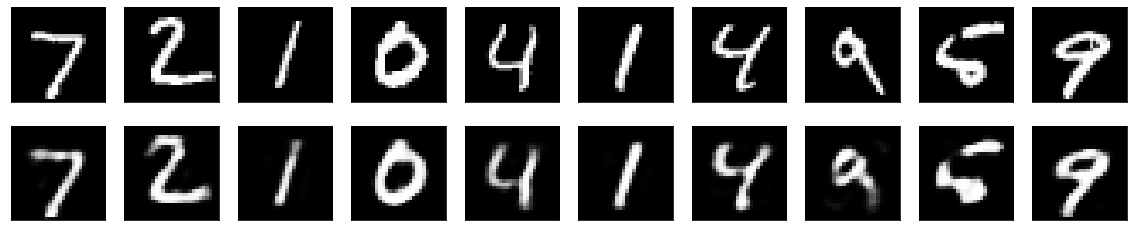

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
